In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.image as mpimg
import tempfile

import boto3

In [4]:
bucket_name = 'msds603-deep-vision'
project_name = 'Oxford-IIIT-Pet'

In [5]:
client = boto3.client('s3')

# Constructing table of files - labels

In [2]:
###### utils #########

def get_label_names(folder_dic):
    return folder_dic['Prefix'].split('/')[-2]


def list_items(client, path=None, only_folders=False, bucket_name='msds603-deep-vision'):
    delimiter = "/" if only_folders else ""
    if path is None: raise ValueError("A path in the bucket is needed")
    else:
        return client.list_objects(Bucket=bucket_name, Prefix=path, Delimiter=delimiter)

    
def get_project_df(client, project, bucket_name='msds603-deep-vision'):
    all_file_paths = []
    all_labels = []
    labels = list_items(client, path=f"{project}/", only_folders=True, bucket_name=bucket_name)
    for folder_dic in labels['CommonPrefixes']:
        label = get_label_names(folder_dic)
        files_obj = list_items(client, path=f"{project}/{label}/", only_folders=False)
        files_paths = [file_obj['Key'] for file_obj in files_obj['Contents'][1:]]
        all_file_paths.extend(files_paths)
        all_labels.extend([label]*len(files_paths))
    return pd.DataFrame(zip(all_file_paths,all_labels), columns=['path','label'])


def get_image(file_path, show=False, bucket_name='msds603-deep-vision'):
    
    tmp = tempfile.NamedTemporaryFile()
    with open(tmp.name, 'wb') as data:
        client.download_fileobj(bucket_name, file_path, data)
        img=mpimg.imread(tmp.name)

    if show: plt.imshow(img); plt.show()
    
    return img


def create_mappings(x: pd.Series):
    labels = x.unique()
    lbl2idx = {label: idx for idx, label in enumerate(labels)}
    return lbl2idx, labels



In [3]:
### Dataset ### 

class project_ds(Dataset):
    
    def __init__(self, client, project_name, bucket_name='msds603-deep-vision'):
        
        self.bucket_name = bucket_name
        df = get_project_df(client, project_name, bucket_name)
        
        self.paths = df.path
        
        self.lbl2idx, self.idx2lbl = create_mappings(df.label)
        
        self.labels = list(map(lambda x: self.lbl2idx[x], df.label))
        
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        x = get_image(self.paths[idx], show=False, 
                      bucket_name=self.bucket_name)
        
        return x, self.labels[idx]


In [6]:
pet_ds = project_ds(client, project_name, bucket_name)

In [7]:
x,y = pet_ds[0]

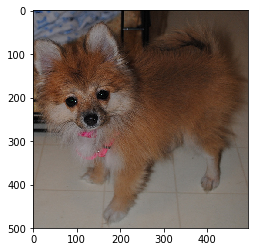

y index: 0
y label: pomeranian


In [8]:
plt.imshow(x)
plt.show()
print(f'y index: {y}\ny label: {pet_ds.idx2lbl[y]}')